In [1]:
import splitwavepy as sw
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
dat = sw.Data(delta=0.1, noise=0.01, split=(30, 1.3))
x0 = dat.x
y0 = dat.y

The correlation and the variance of the data are connected by the covariance.

The Pearson correlation coefficient $\rho$, is maximised between the *fast* and *slow* components when the data are corrected for splitting.
$\rho(X,Y) = \frac{\operatorname{cov}(X,Y)}{\sigma_{X}\sigma_{Y}}$

The variance.  This is equivalent to the energy.  The energy is maximised on the *polarisation* component and minimised on the *transverse* component when the data are corrected for splitting.
$\operatorname{var}(X) = \operatorname{cov}(X,X)$

The covariance is defined as:
$\operatorname{cov}(X,Y) = \operatorname {E} [(X-\operatorname{E}[X])(Y-\operatorname{E}[Y])]$, or calculated using:
$\operatorname{cov}(X,Y) = \frac{1}{n} \Sigma^{n}_{i=1}(x_i - \mu_x)(y_i - \mu_y)$

A faster (but potentially numerically unstable) way to calculate the covariance is:
$\operatorname{cov}(X,Y) = \operatorname {E} [XY] - \operatorname {E}[X] \operatorname {E}[Y]$

The variance-covariance matrix:
$\Sigma _{ij}=\operatorname {cov} (X_{i},X_{j})=\operatorname {E} [(X_{i}-\mu _{i})(X_{j}-\mu _{j})]=\operatorname {E} [X_{i}X_{j}]-\mu _{i}\mu _{j}$




In [62]:
def rotate(x,y,degrees):
    """row 0 is x-axis and row 1 is y-axis,
       rotates from x to y axis
       e.g. N to E if row 0 is N cmp and row1 is E cmp"""
    ang = math.radians(degrees)
    rot = np.array([[ np.cos(ang), np.sin(ang)],
                    [-np.sin(ang), np.cos(ang)]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def rot2(x, y, deg):
    ang = math.radians(deg)
    cang = math.cos(ang)
    sang = math.sin(ang)
    rot = np.array([[ cang, sang],
                    [-sang, cang]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def rot3(x, y, ang):
    cang = math.cos(ang)
    sang = math.sin(ang)
    rot = np.array([[ cang, sang],
                    [-sang, cang]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def get_c(dx, dy):
    c = np.empty((2, 2))
    c[0][0] = np.sum(dx**2)
    c[0][1] = c[1][0] = np.sum(dx*dy)
    c[1][1] = np.sum(dy**2)
    return c / (np.sqrt(c[0][0]) * np.sqrt(c[1][1]))

def slagchop(x, y, w0, w1, slag):
    d = int(slag/2)
    return x[w0+d: w1+d], y[w0-d: w1-d] 

def running_mean(x, w0, w1, slags):
    d = int(slags[-1]/2)
    x = x[w0-d: w1+d]
    n = w1-w0
    return np.convolve(x, np.ones((n,))/n, mode='valid')

def rotmat(ang):
    sang = math.sin(ang)
    cang = math.cos(ang)
    return np.array([[ cang, sang],
                    [-sang, cang]])

# different from np
def cov1(x, y):
    c = np.empty((2, 2))
    n = x.size
    x = x - np.mean(x)
    y = y - np.mean(y)
    exx = np.sum(x*x)
    exy = np.sum(x*y)
    eyy = np.sum(y*y)
    ex = np.sum(x)
    ey = np.sum(y)
    c[0, 0] = exx - ex*ex
    c[0, 1] = c[1, 0] = exy - ex*ey
    c[1, 1] = eyy - ey*ey
    return c / n

# different from np (ratios same)
# faster than cov1 and np
def cov2(x, y):
    c = np.empty((2, 2))
    exx = np.mean(x*x)
    exy = np.mean(x*y)
    eyy = np.mean(y*y)
    ex = np.mean(x)
    ey = np.mean(y)
    c[0, 0] = exx - ex*ex
    c[0, 1] = c[1, 0] = exy - ex*ey
    c[1, 1] = eyy - ey*ey
    return c

# also slower than cov2
def cov3(x, y):
    c = np.empty((2, 2))
    ex = np.mean(x)
    ey = np.mean(y)
    dx = x - ex
    dy = y - ey
    c[0, 0] = np.mean(dx * dx)
    c[0, 1] = c[1, 0] = np.mean(dx * dy)
    c[1, 1] = np.mean(dy * dy)
    return c

# different from np (ratios same)
# faster than cov1 and np
def cov(x, y):
    c = np.empty((2, 2))
    exx = np.mean(x*x)
    exy = np.mean(x*y)
    eyy = np.mean(y*y)
    ex = np.mean(x)
    ey = np.mean(y)
    c[0, 0] = exx - ex*ex
    c[0, 1] = c[1, 0] = exy - ex*ey
    c[1, 1] = eyy - ey*ey
    return c

# slower
# def running_mean2(x, w0, w1, maxslag):
#     d = int(maxslag/2)
#     x = x[w0-d: w1+d]
#     n = w1-w0
#     cumsum = np.cumsum(np.insert(x, 0, 0))
#     return (cumsum[n:] - cumsum[:-n]) / float(n)


In [79]:
degs = np.linspace(0, 180, 180, endpoint=False)
rads = np.radians(degs)
lags = np.linspace(0, 8, 60)
slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))

def gridcov(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x, y, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
#             print(ii,jj,c)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# this is actually just as fast as using list comprehension and arguably more readable
def gridcov_loops(x, y, w0, w1, degs, slags):
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for deg in degs:  
        # prepare a list of data rotated to degs
        rot = rot2(x, y, deg)
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
#             print(ii,jj,c)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# this is the fastest implementation yet
def gridcov_loops2(x, y, w0, w1, degs, slags):
    # prepare empty covariance arrays
    g = np.empty((degs.size, slags.size, 2, 2))
    n = w1 - w0
    # now loop and calculate
    for ii in range(degs.size):
        # prepare a list of data rotated to degs
#         deg = degs[ii] 
        # prepare a list of data rotated to degs
        rot = rot2(x, y, degs[ii])
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        # loop over lags
        for jj in range(slags.size):
            slag = slags[jj]
            wx, wy  = slagchop(rot[0], rot[1], w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            g[ii, jj, 0, 0] = np.sum(dx * dx)
            g[ii, jj, 1, 0] = g[ii, jj, 0, 1] = np.sum(dx * dy)
            g[ii, jj, 1, 1] = np.sum(dy * dy)
    return g / n

# give rads instead -- no soeedup (if anything slightly slower)
def gridcov_loops3(x, y, w0, w1, rads, slags):
    # prepare empty covariance arrays
    g = np.empty((rads.size, slags.size, 2, 2))
    n = w1 - w0
    # now loop and calculate
    for ii in range(rads.size):
        # prepare a list of data rotated to degs
        rot = rot2(x, y, rads[ii])
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        # loop over lags
        for jj in range(slags.size):
            slag = slags[jj]
            wx, wy  = slagchop(rot[0], rot[1], w0, w1, slags[jj])
            dx, dy = wx - meanx[slag], wy - meany[slag]
            g[ii, jj, 0, 0] = np.sum(dx * dx)
            g[ii, jj, 1, 0] = g[ii, jj, 0, 1] = np.sum(dx * dy)
            g[ii, jj, 1, 1] = np.sum(dy * dy)
    return g / n

# this is the fastest implementation yet
def gridcov_loops4(x, y, w0, w1, degs, slags):
    # prepare empty covariance arrays
    g = np.empty((degs.size, slags.size, 2, 2))
    n = w1 - w0
    npsum = np.sum # remove dots from inner loop
    # now loop and calculate
    for ii in range(degs.size):
        # prepare a list of data rotated to degs
#         deg = degs[ii] 
        # prepare a list of data rotated to degs
        rot = rot2(x, y, degs[ii])
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        # loop over lags
        for jj in range(slags.size):
            slag = slags[jj]
            wx, wy  = slagchop(rot[0], rot[1], w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            g[ii, jj, 0, 0] = npsum(dx * dx)
            g[ii, jj, 1, 0] = g[ii, jj, 0, 1] = npsum(dx * dy)
            g[ii, jj, 1, 1] = npsum(dy * dy)
    return g / n

# gridcov2 -- using the "trick" that cov(x,y) =  E[xy] - E[x]E[y] 
# this is slower than gridcov
# probably because the calculation of dx and dy is useful for calculating variances quickly.
def gridcov2(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x, y, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
#             dx, dy = wx - meanx[slag], wy - meany[slag]
            exy = np.mean(wx * wy)
            ex = meanx[slag]
            ey = meany[slag]
            c[0, 0] = np.var(wx)
            c[1, 0] = c[0, 1] = exy - ex * ey
            c[1, 1] = np.var(wy)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# gridcov3 -- using numpy.cov function explicitly
# this is even slower than gridcov2.
def gridcov3(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x, y, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            gridcov[ii, jj, :, :] = np.cov(wx,wy)
            jj += 1
        ii += 1
    return gridcov

# gridcov4 -- don't precalculate means
# as expected this is slower than gridcov, but faster than others.
# something like this is probably needed if source correction needs to be applied
def gridcov4(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x, y, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            mx, my = np.mean(wx), np.mean(wy)
            dx, dy = wx - mx, wy - my
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# gridcov5 -- use cov in list comprehension
def gridcov5(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x, y, deg) for deg in degs ]
    # grid search
    gridcov = [ [ cov(*slagchop(*rot, w0, w1, slag)) for slag in slags ] for rot in rot_data ]
    return np.asarray(gridcov)



In [5]:
x, y, w0, w1 = dat.x, dat.y, dat._w0(), dat._w1()

In [6]:
%timeit gridcov(x, y, w0, w1, degs, slags)
c = gridcov(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# # silver and chan transenergy method
# pol = 0
# var = np.empty(c.shape)
# # rotmats = np.asarray([ rotmat(math.radians(pol-deg)) for deg in degs ])
# # var = np.tensordot(c, rotmats, 2)
# for ii in range(degs.size):
#     r = rotmat(math.radians(pol-degs[jj]))
#     for jj in range(slags.size):
#         var[ii,jj,:,:] = np.dot(r, c[ii,jj,:,:])
        
# var1 = var[:,:,0,0]
# var2 = var[:,:,1,1]



10 loops, best of 3: 139 ms per loop


In [7]:
%timeit gridcov_loops(x, y, w0, w1, degs, slags)
# c = gridcov(x, y, w0, w1, degs, slags)


10 loops, best of 3: 140 ms per loop


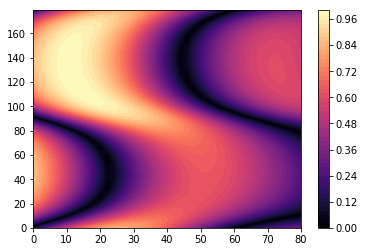

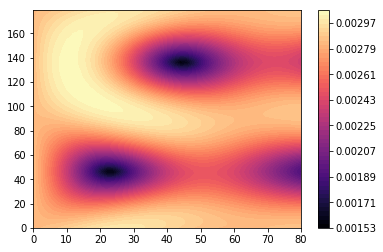

In [8]:
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

1 loop, best of 3: 349 ms per loop


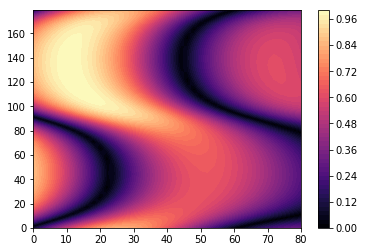

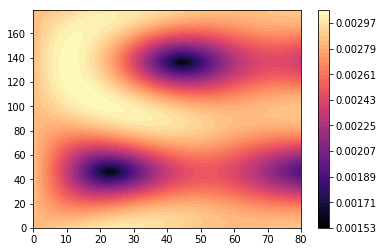

In [9]:
%timeit gridcov2(x, y, w0, w1, degs, slags)

c = gridcov2(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

1 loop, best of 3: 377 ms per loop


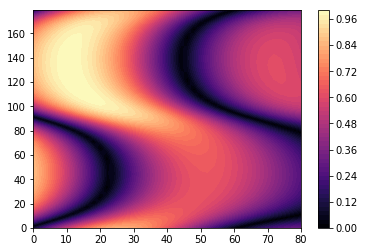

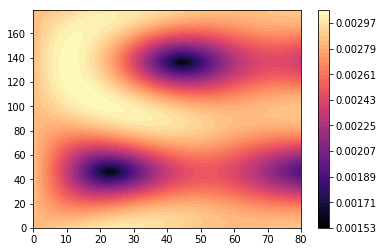

In [10]:
%timeit gridcov3(x, y, w0, w1, degs, slags)

c = gridcov2(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

1 loop, best of 3: 222 ms per loop


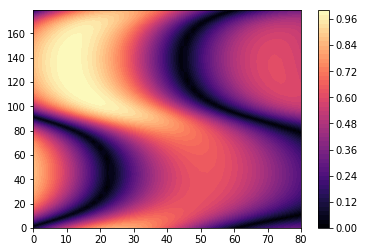

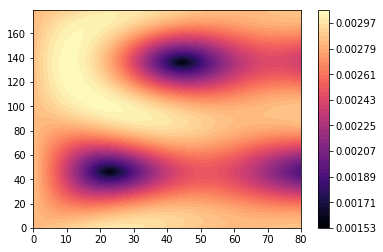

In [11]:
%timeit gridcov4(x, y, w0, w1, degs, slags)

c = gridcov4(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

In [12]:
%timeit gridcov2(x, y, w0, w1, degs, slags)

1 loop, best of 3: 335 ms per loop


In [13]:
dat._w1()

659

In [14]:
np.convolve?

In [15]:
eigvals, eigvecs = np.linalg.eigh(c[:,:])

In [16]:
eigvals[:,:,0]

array([[ 0.00020773,  0.00020248,  0.00019358, ...,  0.0001931 ,
         0.00019118,  0.00018979],
       [ 0.00020773,  0.000205  ,  0.00019844, ...,  0.0001955 ,
         0.00019359,  0.00019212],
       [ 0.00020773,  0.00020754,  0.00020338, ...,  0.00019903,
         0.00019719,  0.00019568],
       ..., 
       [ 0.00020773,  0.00019508,  0.0001795 , ...,  0.00019267,
         0.00019096,  0.0001901 ],
       [ 0.00020773,  0.00019752,  0.00018411, ...,  0.0001917 ,
         0.00018988,  0.0001888 ],
       [ 0.00020773,  0.00019999,  0.0001888 , ...,  0.00019184,
         0.00018995,  0.00018869]])

In [17]:
# degs = np.linspace(0, 180, 90, endpoint=False)
# lags = np.linspace(0, 8, 30)
# slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))
# %timeit gridcov(x, y, w0, w1, degs, slags)

1 loop, best of 3: 255 ms per loop


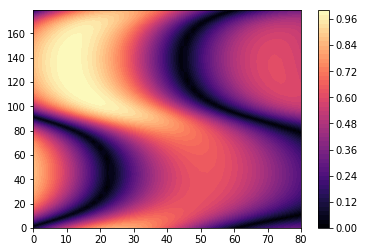

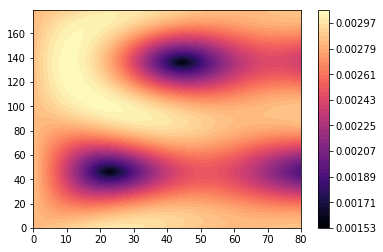

In [18]:
%timeit gridcov5(x, y, w0, w1, degs, slags)
c = gridcov5(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

In [19]:
%timeit np.cov(x, y, bias=1)
print('numpy\n', np.cov(x,y))

%timeit cov1(x, y)
print('cov1\n', cov1(x, y))

%timeit cov2(x, y)
print('cov2\n', cov2(x, y))

%timeit cov3(x, y)
print('cov3\n', cov3(x, y))

10000 loops, best of 3: 48.4 µs per loop
numpy
 [[  9.48050237e-04   1.94823903e-05]
 [  1.94823903e-05   7.24075801e-05]]
10000 loops, best of 3: 38.5 µs per loop
cov1
 [[  9.47091643e-04   1.94626912e-05]
 [  1.94626912e-05   7.23343672e-05]]
10000 loops, best of 3: 35 µs per loop
cov2
 [[  9.47091643e-04   1.94626912e-05]
 [  1.94626912e-05   7.23343672e-05]]
10000 loops, best of 3: 39.4 µs per loop
cov3
 [[  9.47091643e-04   1.94626912e-05]
 [  1.94626912e-05   7.23343672e-05]]


In [20]:
a = np.cov(x, y)
b = cov2(x, y)
print('var1/var2')
print(a[0][0]/a[1][1])
print(b[0][0]/b[1][1])
print('rho')
print(a[0][1]/(np.sqrt(a[0][0])*np.sqrt(a[1][1])))
print(b[0][1]/(np.sqrt(b[0][0])*np.sqrt(b[1][1])))

var1/var2
13.0932457051
13.0932457051
rho
0.0743591722914
0.0743591722914


In [21]:
%timeit cov2(x, y)

10000 loops, best of 3: 34.5 µs per loop


In [22]:
def slagchop_srccorr(x, y, w0, w1, slag, srcfast, srcslag):
    x, y = rot2(x, y, srcfast)
    x, y = lag(x, y, srcslag)
    x, y = rot2(x, y, -srcfast)
    d = int(slag/2) - int(srcslag/2)
    return x[w0+d: w1+d], y[w0-d: w1-d]

def gridcov_srcorr(x, y, w0, w1, degs, slags, srcfast, srcslag):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        jj = 0
        for slag in slags:
            wx, wy  = slagchop_srccorr(*rot, w0, w1, slag, srcfast, srcslag)
            mx, my = np.mean(wx), np.mean(wy)
            dx, dy = wx - mx, wy - my
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

In [23]:
from numba import jit, prange

# @jit(nopython=True)
# def rotation_matrix(ang):
#     cang = math.cos(ang)
#     sang = math.sin(ang)
#     r = np.empty((2,2))
#     r[0][0] = r[1][1] = cang
#     r[0][1] = sang 
#     r[1][0] = -sang
#     return r

@jit(nopython=True)
def rotjit(x, y, deg):
    ang = math.radians(deg)
    cang = math.cos(ang)
    sang = math.sin(ang)
    r = np.empty((2,2))
    r[0][0] = r[1][1] = cang
    r[0][1] = sang 
    r[1][0] = -sang
    xy = np.dot(r, np.vstack((x,y)))
    return xy[0], xy[1]

@jit(nopython=True)
def running_mean_jit(x, w0, w1, slags):
    d = int(slags[-1]/2)
    x = x[w0-d: w1+d]
    n = w1-w0
    c = np.convolve(x, np.ones((n,))/n)
    # reproduce 'valid' mode
    v = n - 1
    return c[v: -v]

@jit(nopython=True)
def slagchop_jit(x, y, w0, w1, slag):
    d = int(slag/2)
    return x[w0+d: w1+d], y[w0-d: w1-d]

@jit(fastmath=True)
def gridcov_jit(x, y, w0, w1, degs, slags):
    # prepare empty covariance arrays
    g = np.empty((degs.size, slags.size, 2, 2))
    n = w1 - w0
    npsum = np.sum
    # now loop and calculate
    for ii in prange(degs.size):
        # prepare a list of data rotated to degs
        deg = degs[ii]
        rot = rotjit(x, y, deg)
        # precalculate mean in each window
        meanx = running_mean_jit(rot[0], w0, w1, slags)
        meany = running_mean_jit(rot[1], w0, w1, slags)
        # loop over lags
        for jj in range(slags.size):
            slag = slags[jj]
            wx, wy  = slagchop_jit(rot[0], rot[1], w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]       
            g[ii, jj, 0, 0] = np.sum(dx * dx)
            g[ii, jj, 1, 0] = g[ii, jj, 0, 1] = np.sum(dx * dy)
            g[ii, jj, 1, 1] = np.sum(dy * dy)
    return g / n

# c = gridcov_jit(x, y, w0, w1, degs, slags)

In [24]:
c = gridcov_jit(x, y, w0, w1, degs, slags)
d = gridcov(x, y, w0, w1, degs, slags)
np.allclose(c,d)

True

In [25]:
%timeit gridcov_jit(x, y, w0, w1, degs, slags)

10 loops, best of 3: 119 ms per loop


In [26]:
%timeit gridcov(x, y, w0, w1, degs, slags)

10 loops, best of 3: 138 ms per loop


In [82]:
%timeit gridcov_loops2(x, y, w0, w1, degs, slags)
%timeit gridcov_loops4(x, y, w0, w1, degs, slags)

10 loops, best of 3: 114 ms per loop
10 loops, best of 3: 112 ms per loop


In [77]:
def _rot(x, y, deg):
    ang = math.radians(deg)
    cang = math.cos(ang)
    sang = math.sin(ang)
    rot = np.array([[ cang, sang],[-sang, cang]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def _rot2(x, y, deg):
    ang = math.radians(deg)
    cang = math.cos(ang)
    sang = math.sin(ang)
    rot = [[ cang, sang],[-sang, cang]]
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def _rot3(x, y, deg):
    ang = math.radians(deg)
    cang = math.cos(ang)
    sang = math.sin(ang)
    r = np.empty((2,2))
    r[0][0] = r[1][1] = cang
    r[0][1] = sang 
    r[1][0] = -sang
    xy = np.dot(r, np.vstack((x,y)))
    return xy[0], xy[1]

In [78]:
%timeit rot(x, y, 10)
%timeit rot2(x, y, 10)
%timeit rot3(x, y, 10)

The slowest run took 7.00 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.18 µs per loop
The slowest run took 4.83 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.31 µs per loop
The slowest run took 6.38 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.24 µs per loop


In [30]:
# @jit(nopython=True)
# def rotjit(x, y, deg):
#     ang = math.radians(deg)
#     cang = math.cos(ang)
#     sang = math.sin(ang)
#     rot = np.array([[ cang, sang],[-sang, cang]])
#     xy = np.dot(rot, np.vstack((x, y)))
#     return xy[0], xy[1]

@jit(nopython=True)
def rotation_matrix(ang):
    cang = math.cos(ang)
    sang = math.sin(ang)
    r = np.empty((2,2))
    r[0][0] = r[1][1] = cang
    r[0][1] = sang 
    r[1][0] = -sang
    return r

In [31]:
rotation_matrix(10)

array([[-0.83907153, -0.54402111],
       [ 0.54402111, -0.83907153]])

In [32]:
@jit(nopython=True)
def jitdot(x, y):
    return np.dot(x, y)

In [33]:
r = np.array([[1.,0.],[0.,1.]])
xy = np.vstack((x, y))
jitdot(r, xy)

array([[ 0.00019246,  0.00033165,  0.00048152, ..., -0.00249441,
        -0.00235503, -0.00218511],
       [-0.00172324, -0.00190579, -0.00207874, ...,  0.00153347,
         0.00132535,  0.00112975]])

In [34]:
jitdot.inspect_types()

jitdot (array(float64, 2d, C), array(float64, 2d, C))
--------------------------------------------------------------------------------
# File: <ipython-input-32-708028a54cf6>
# --- LINE 1 --- 
# label 0
#   del $0.1
#   del y
#   del x
#   del $0.2
#   del $0.5

@jit(nopython=True)

# --- LINE 2 --- 

def jitdot(x, y):

    # --- LINE 3 --- 
    #   x = arg(0, name=x)  :: array(float64, 2d, C)
    #   y = arg(1, name=y)  :: array(float64, 2d, C)
    #   $0.1 = global(np: <module 'numpy' from '/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/__init__.py'>)  :: Module(<module 'numpy' from '/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/__init__.py'>)
    #   $0.2 = getattr(attr=dot, value=$0.1)  :: Function(<built-in function dot>)
    #   $0.5 = call $0.2(x, y, func=$0.2, kws=[], vararg=None, args=[Var(x, <ipython-input-32-708028a54cf6> (3)), Var(y, <ipython-input-32-708028a54cf6> (3))])  :: (array(float64, 2d, C), array(float64, 2d, C)) -> array(floa

In [35]:
np.convolve(x, y).size

1977

In [36]:
x.size

989

In [37]:
1977 - 989

988

In [38]:
np.convolve(x, y).size

1977

In [39]:
# np.convolve(x, y)[1977-989]
np.convolve(x, y)[y.size-1:-(y.size-1)]

array([-0.05833148])

In [40]:
np.convolve(x, y, 'valid')

array([-0.05833148])

In [41]:
def running_mean(x, w0, w1, slags):
    d = int(slags[-1]/2)
    x = x[w0-d: w1+d]
    n = w1-w0
    return np.convolve(x, np.ones((n,))/n, mode='valid')

def running_mean2(x, w0, w1, slags):
    d = int(slags[-1]/2)
    x = x[w0-d: w1+d]
    n = w1-w0
    c = np.convolve(x, np.ones((n,))/n)
    # reproduce 'valid' mode
    v = n - 1
    return c[v: -v]

In [42]:
running_mean(x, w0, w1, slags) - running_mean2(x, w0, w1, slags)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [43]:
np.sum([1,1])

2

In [44]:
@jit(parallel=True)
def sumjit(x):
    y = np.empty((10,3))
    for ii in prange(10):
        for jj in range(3):
            dx = x - 3
            y[ii,jj] = np.sum(dx*ii*jj)
    return y

sumjit(np.arange(100))

array([[     0.,      0.,      0.],
       [     0.,   4650.,   9300.],
       [     0.,   9300.,  18600.],
       [     0.,  13950.,  27900.],
       [     0.,  18600.,  37200.],
       [     0.,  23250.,  46500.],
       [     0.,  27900.,  55800.],
       [     0.,  32550.,  65100.],
       [     0.,  37200.,  74400.],
       [     0.,  41850.,  83700.]])

In [45]:
%load_ext line_profiler
%lprun -s -f gridcov -T lp_results.txt gridcov(x, y, w0, w1, degs, slags)
%cat lp_results.txt


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 0.238257 s
File: <ipython-input-4-f0a2a1611b3b>
Function: gridcov at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def gridcov(x, y, w0, w1, degs, slags):
     6                                               # prepare a list of data rotated to degs
     7         1       2924.0   2924.0      1.2      rot_data = [ rot2(x, y, deg) for deg in degs ]
     8                                               # prepare empty covariance arrays
     9         1          5.0      5.0      0.0      gridcov = np.empty((degs.size, slags.size, 2, 2))
    10         1          1.0      1.0      0.0      c = np.empty((2, 2))
    11         1          0.0      0.0      0.0      ii = 0
    12                                               # now loop and calculate
    13       181        136.0      0.8      0.1      for rot in rot_data:  
    14

In [50]:

%lprun -s -f gridcov_loops2 -T lp_results.txt gridcov_loops2(x, y, w0, w1, degs, slags)
%cat lp_results.txt


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 0.200245 s
File: <ipython-input-48-2dbf7ee1bdcf>
Function: gridcov_loops2 at line 61

Line #      Hits         Time  Per Hit   % Time  Line Contents
    61                                           def gridcov_loops2(x, y, w0, w1, degs, slags):
    62                                               # prepare empty covariance arrays
    63         1          9.0      9.0      0.0      g = np.empty((degs.size, slags.size, 2, 2))
    64         1          1.0      1.0      0.0      n = w1 - w0
    65                                               # now loop and calculate
    66       181         86.0      0.5      0.0      for ii in prange(degs.size):
    67                                                   # prepare a list of data rotated to degs
    68       180        114.0      0.6      0.1          deg = degs[ii] 
    69                                                   # prepare a list of data 